<img src="https://www.companieshistory.com/wp-content/uploads/2013/07/ConocoPhillips.png"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 5px;" />
     Objective of the project to used sensor information to predict plan failure


In [91]:
import pandas as pd
import numpy as np 
import seaborn as sns 
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
# we will have to play with the error to figure out which meter is best to train the data
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [99]:
#importing the data
test_df = pd.read_csv('equipfails/equip_failures_test_set.csv')
train_df = pd.read_csv('equipfails/equip_failures_training_set.csv')

In [103]:
train_df = train_df.drop(columns = 'id')
train_df = train_df.replace('na',np.nan)
train_df_na = (train_df.isnull().sum()/len(train_df))*100
train_df_na = train_df_na.drop(train_df_na[train_df_na == 0].index).sort_values(ascending=False)

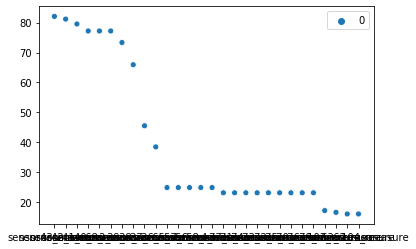

In [104]:
train_df_na = pd.DataFrame(train_df_na)
train_df_na[train_df_na[0] > 15]
sns.scatterplot( data = (train_df_na[train_df_na[0] > 15]))            

In [116]:
feature_drop = train_df_na[train_df_na[0] > 30].index
Data_train = train_df.drop(columns = feature_drop)

#Data_train = Data_train[test_df_needed.columns]
Data_train.head()

ValueError: Lengths must match to compare

In [106]:
# We are replacing the missing values with the data 
Data_train = Data_train.fillna(0)
Data_train.head()

,target,sensor1_measure,sensor3_measure,sensor4_measure,sensor5_measure,sensor6_measure,sensor7_histogram_bin0,sensor7_histogram_bin1,sensor7_histogram_bin2,sensor7_histogram_bin3,...,sensor105_histogram_bin2,sensor105_histogram_bin3,sensor105_histogram_bin4,sensor105_histogram_bin5,sensor105_histogram_bin6,sensor105_histogram_bin7,sensor105_histogram_bin8,sensor105_histogram_bin9,sensor106_measure,sensor107_measure
0,0,76698,2130706438,280,0,0,0,0,0,0,...,1240520,493384,721044,469792,339156,157956,73224,0,0,0
1,0,33058,0,0,0,0,0,0,0,0,...,421400,178064,293306,245416,133654,81140,97576,1500,0,0
2,0,41040,228,100,0,0,0,0,0,0,...,277378,159812,423992,409564,320746,158022,95128,514,0,0
3,0,12,70,66,0,10,0,0,0,318,...,240,46,58,44,10,0,0,0,4,32
4,0,60874,1368,458,0,0,0,0,0,0,...,622012,229790,405298,347188,286954,311560,433954,1218,0,0


#### Creating a Training and validation set to train the model base of the reliable feature 

In [107]:
X = Data_train[Data_train.columns[Data_train.columns != 'target']]
y = Data_train['target']
train_X, val_X, train_y, val_y  = train_test_split(X, y, test_size=0.33, random_state=42)

In [108]:
descision_tree_model = tree.DecisionTreeClassifier(random_state=1)
# Fit Model
descision_tree_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = descision_tree_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print((val_mae))

0.010959595959595959


In [95]:
descision_tree_model = DecisionTreeRegressor(random_state=1)
# Fit Model
descision_tree_model.fit(train_X, train_y)

# Make validation predictions and calculate mean absolute error
val_predictions = descision_tree_model.predict(val_X)
val_mae = mean_absolute_error(val_predictions, val_y)
print((val_mae))

0.010959595959595959


In [123]:
test_df_no_id  = test_df.drop(columns= 'id')
test_df_needed = test_df_no_id.drop(columns = feature_drop)
test_df_needed = test_df_needed.replace('na',np.nan)
test_df_needed = test_df_needed.fillna(0)
test_preds = descision_tree_model.predict(test_df_needed)

In [140]:
output = pd.DataFrame({'Id': test_df['id'],
                       'target': test_preds})
output.to_csv('submission.csv', index=False)